In [1]:
!pip install backtesting
import scipy
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pandas_ta as ta
import yfinance as yahooFinance
import datetime
!pip install pandas_ta
import pandas_ta as ta

In [2]:
GetFacebookInformation = yahooFinance.Ticker("META")
startDate = datetime.datetime(2012, 5, 31)

# endDate , as per our convenience we can modify
endDate = datetime.datetime(2024, 4, 30)
data = GetFacebookInformation.history(start=startDate,
                                     end=endDate)

In [3]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(24).shift(-24)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

In [4]:
from scipy.stats import linregress

def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
upper, lower = BBANDS(data, 20, 2)


# Price-derived features
data['MA20'] = data.ta.sma(length=20)
data['MA50'] = data.ta.sma(length=50)
data['MA200'] = data.ta.sma(length=200)
data['X_RSI'] = data.ta.rsi()
data['X_EMA']=ta.sma(data.Close, length=200)#sma ema

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close

In [5]:
data = data.dropna().astype(float)


In [ ]:
X, y = get_clean_Xy(data)

Classification accuracy:  0.6594594594594595


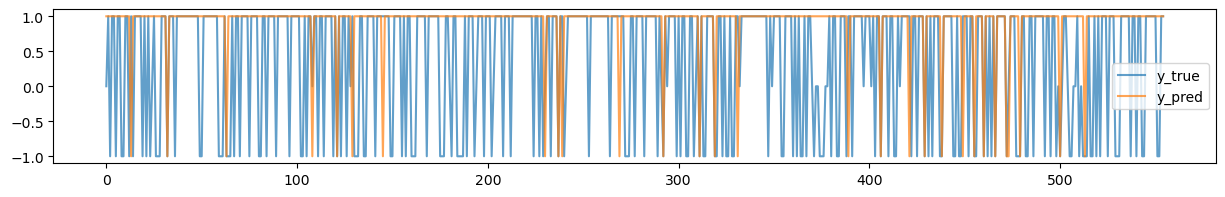

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import svm
X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
clfsvm = svm.SVC()
clfsvm.fit(X_train, y_train)
y_pred = clfsvm.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))
